# Convolutional Neural Network CNN Model

**Importing libraries**

In [39]:
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

**Loading dataset and extracting features for training and test dataset**



In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import ast # To safely parse string representations of lists
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from sklearn.preprocessing import StandardScaler # Import StandardScaler for robust scaling

# Read the CSV file into a DataFrame
df = pd.read_csv('Sample_Step_dataset.csv')

# The CNN model in cell zUbSrhcbVf98 has input_shape=(32, 32, 3),
# which means each image should have 32 * 32 * 3 = 3072 features per image.
expected_cnn_features_per_image = 32 * 32 * 3

# --- Feature Extraction ---
# Based on inspection, the DataFrame likely has non-numeric columns ('KEY', 'ENTITY')
# and numerical 'D' columns ('D0' to 'D7').
# The current `X = df.iloc[:, :-1].values` includes non-numeric data, causing TypeError.
# We will assume 'D0' to 'D7' are the intended numerical features.
numerical_feature_columns = [f'D{i}' for i in range(8)]
if all(col in df.columns for col in numerical_feature_columns):
    X = df[numerical_feature_columns].values
else:
    print("Warning: Expected 'D0' through 'D7' columns not found. Attempting to use all numerical columns.")
    X = df.select_dtypes(include=np.number).drop(columns=['KEY'], errors='ignore').values # Exclude KEY if it's an identifier
    if X.shape[1] == 0:
        raise ValueError("No numerical features found in the DataFrame to be used as input.")

print(f"Extracted features shape: {X.shape}")

# --- Label Extraction and Processing ---
# Assuming the last column is the label and it's a string representation of a list (e.g., '[]', '[123]', '[1, 2]').
y_raw = df.iloc[:, -1].values
y_processed = []
num_classes_found_set = set() # Renamed to avoid confusion with processed y
for label_str in y_raw:
    try:
        label_list = ast.literal_eval(label_str) # Safely parse string as Python literal
        if isinstance(label_list, list) and label_list:
            # For SparseCategoricalCrossentropy, we need a single integer class per sample.
            # If it's multi-label (list with multiple items), this simplification might lose information.
            # Taking the first label found, or 0 if empty.
            y_processed.append(int(label_list[0]))
            num_classes_found_set.add(int(label_list[0]))
        else:
            y_processed.append(0) # Assign a default class 0 for empty labels
            num_classes_found_set.add(0)
    except (ValueError, SyntaxError):
        print(f"Warning: Could not parse label string '{label_str}'. Assigning 0.")
        y_processed.append(0)
        num_classes_found_set.add(0)
y_unencoded = np.array(y_processed) # Store unencoded labels for clarity

# Encode labels to a contiguous range starting from 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_unencoded)
num_classes = len(label_encoder.classes_) # Get the actual number of classes after encoding

print(f"Processed labels shape (unencoded): {y_unencoded.shape}")
print(f"Processed and encoded labels shape: {y_encoded.shape}")
print(f"Number of unique classes found after encoding: {num_classes}")

# --- Data Split ---
# The 'stratify=y' parameter caused an error because many classes have only one member.
# Removing it for now. If class imbalance is an issue, consider other methods.
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42 # Use y_encoded for splitting
)

# --- Normalization (Standardization for Tabular Data) ---
# The previous division by 255.0 was inappropriate for tabular data.
# Using StandardScaler to transform features to have a mean of 0 and std dev of 1.
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images).astype(np.float32) # Explicitly cast to float32
test_images = scaler.transform(test_images).astype(np.float32)   # Explicitly cast to float32
print("Features standardized successfully.")

# --- Reshaping for CNN (Critical Mismatch) ---
# This warning is still relevant if the intent was to use a CNN with image-like data.
# However, since the model was changed to Dense layers, this reshaping is no longer needed,
# but the warning serves as a reminder of the original context.
if train_images.shape[1] == expected_cnn_features_per_image:
    # This block will likely not be reached with current data (8 features)
    train_images = train_images.reshape(-1, 32, 32, 3)
    test_images = test_images.reshape(-1, 32, 32, 3)
    print("Features reshaped for CNN input.")
else:
    print(f"Warning: Number of features per sample in CSV ({train_images.shape[1]}) "
          f"does not match the expected {expected_cnn_features_per_image} for a (32, 32, 3) image. "
          "This is tabular data, and the model has been adjusted to use Dense layers accordingly.")


Extracted features shape: (2030, 8)
Processed labels shape (unencoded): (2030,)
Processed and encoded labels shape: (2030,)
Number of unique classes found after encoding: 1082
Features standardized successfully.


**Fitting into sequental model**

In [41]:
model = models.Sequential()
# Input layer for tabular data (8 features from D0-D7)
# Use X.shape[1] for robustness, which is 8 features.
model.add(layers.Dense(128, activation='relu', input_shape=(X.shape[1],)))
# Hidden layer
model.add(layers.Dense(64, activation='relu'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Model summary**

In [42]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,408 (36.75 KB)

 Trainable params: 9,408 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# The Flatten layer is not needed for tabular data (already 2D: samples x features)
# Add another dense layer if desired
model.add(layers.Dense(32, activation='relu'))

# Final output layer with the number of unique classes found
# Use 'num_classes' which is derived from the LabelEncoder, ensuring it's accurate.
# No activation here, as SparseCategoricalCrossentropy(from_logits=True) will be used.
model.add(layers.Dense(num_classes))


**Model density**

In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1082)           │        35,706 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,194 (184.35 KB)

 Trainable params: 47,194 (184.35 KB)

 Non-trainable params: 0 (0.00 B)

**Fitting into model with epoch of 5**

In [45]:
# Adam is the best among the adaptive optimizers in most of the cases
# If loss is nan, a common fix is to reduce the learning rate.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Reduced learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Check for NaNs or Infs in training data and labels before fitting
if np.isnan(train_images).any() or np.isinf(train_images).any():
    print("ERROR: NaN or Inf values found in train_images after preprocessing!")
if np.isnan(train_labels).any() or np.isinf(train_labels).any():
    print("ERROR: NaN or Inf values found in train_labels after preprocessing!")

# An epoch means training the neural network with all the
# training data for one cycle. Here I use 10 epochs
history = model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 3.0731e-04 - loss: 6.9836 - val_accuracy: 0.0000e+00 - val_loss: 6.9695
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1593 - loss: 6.9543 - val_accuracy: 0.3054 - val_loss: 6.9498
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3646 - loss: 6.9166 - val_accuracy: 0.3128 - val_loss: 6.9141
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3781 - loss: 6.8516 - val_accuracy: 0.3128 - val_loss: 6.8512
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3784 - loss: 6.7331 - val_accuracy: 0.3128 - val_loss: 6.7337


**Graph plot for accuracy and epoch**

13/13 - 0s - 4ms/step - accuracy: 0.3128 - loss: 6.7337


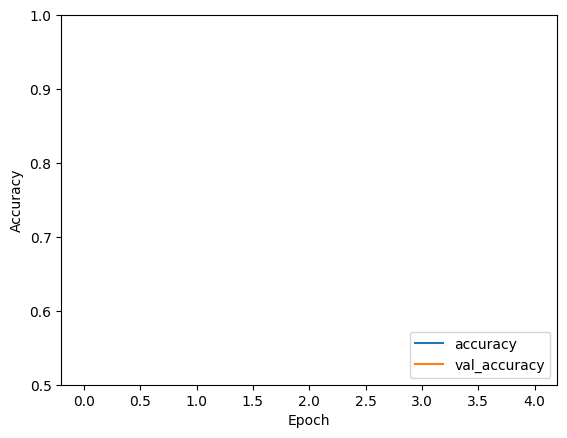

In [47]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,
                                     test_labels,
                                     verbose=2)

**Calculation of accuracy**

In [48]:
print('Test Accuracy is',test_acc)

Test Accuracy is 0.3128078877925873


In [49]:
!pip install keras

In [50]:
!pip install np_utils

**Applying sequental model for flattern and density using rele and softmax activation**

In [51]:
#
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
